In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\Short-Term WTI Price Forecasting\Temp prediction\Data.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df['Texas'] = pd.to_numeric(df['Texas'])
df = df.sort_values(by='DATE', ascending=True)
df = df.set_index('DATE')
df = df.drop(columns=['Dubai','UK','Dubai Price','WTI', 'Brent'])
df = df.asfreq(pd.infer_freq(df.index))
df = df.resample('W').mean()
df = df.dropna()
df

,Texas
DATE,
2020-07-12,26.875
2020-07-19,28.960
2020-07-26,26.940
2020-08-02,27.340
2020-08-09,29.400
...,...
2024-08-11,27.650
2024-08-18,29.500
2024-08-25,30.100


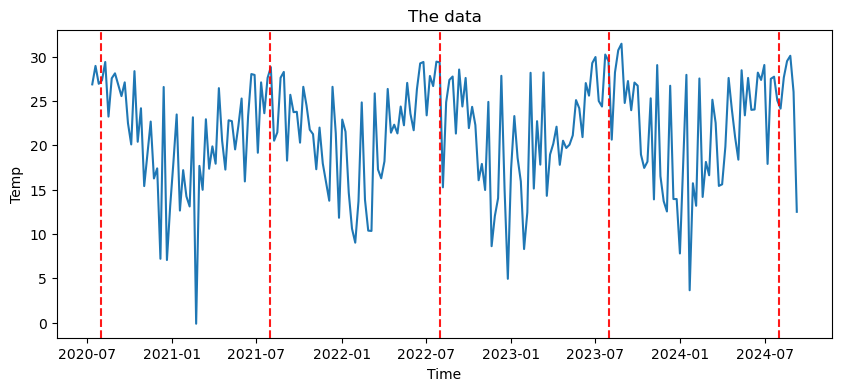

In [18]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('The data')
plt.xlabel('Time')
plt.ylabel('Temp')
for year in range(2020,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-31'),color='r',linestyle='--',alpha=0.9)

In [19]:
result = adfuller(df['Texas'])
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.00


In [20]:
print(len(df))

216


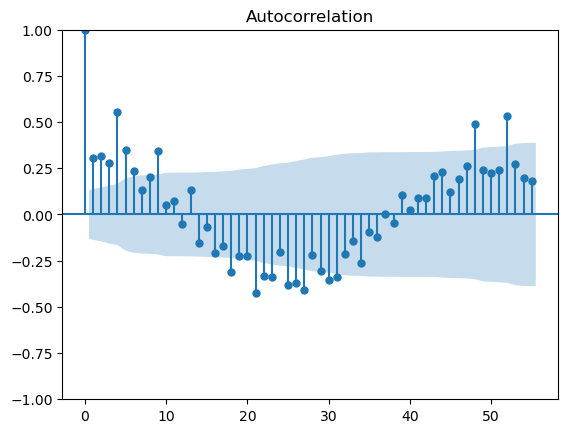

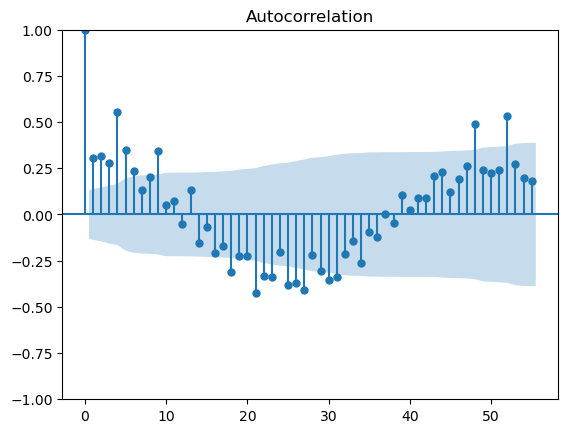

In [21]:
plot_acf(df, lags=55)

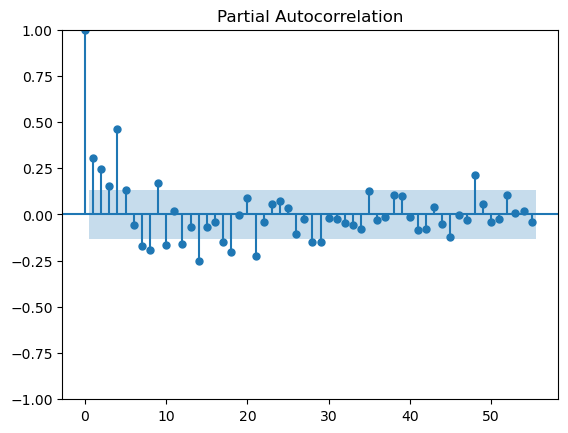

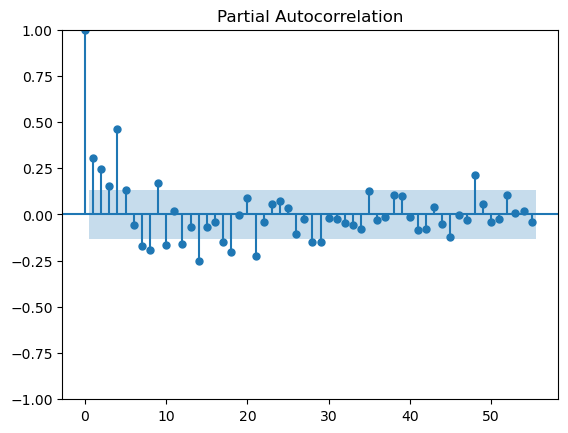

In [22]:
plot_pacf(df, lags=55)

In [23]:
train_end = datetime(2024,5,31)

train_data=df[:train_end]
test_data=df[train_end + timedelta(days=1):]
test_data

,Texas
DATE,
2024-06-02,24.000
2024-06-09,24.040
2024-06-16,28.200
2024-06-23,27.375
2024-06-30,29.060
2024-07-07,17.900
2024-07-14,27.500
2024-07-21,27.740
2024-07-28,25.060


In [24]:
integrated_order=(0,0,0)
seasonal_order = (1,0,1,52)

model = SARIMAX(train_data, order=integrated_order , seasonal_order=seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                 SARIMAX Results                                  
Dep. Variable:                      Texas   No. Observations:                  201
Model:             SARIMAX(1, 0, [1], 52)   Log Likelihood                -663.108
Date:                    Sun, 22 Sep 2024   AIC                           1332.216
Time:                            00:31:10   BIC                           1342.126
Sample:                                 0   HQIC                          1336.226
                                    - 201                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52       0.9943      0.004    246.840      0.000       0.986       1.002
ma.S.L52      -0.4337      0.120     -3.622      0.000      -0.668      -0.199
sigma2        17.128

In [25]:
rolling_predictions=pd.Series(index=test_data.index)

for i in test_data.index:
    train_data = df[:i-timedelta(days=1)] #slicing when dealing with datetime is inclusive man so minus one day
    model = SARIMAX(train_data, order=integrated_order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    prediction = model_fit.forecast(1)
    rolling_predictions.loc[i] = prediction.item()
rolling_predictions

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Bog

DATE
2024-06-02    20.135253
2024-06-09    25.984250
2024-06-16    26.638505
2024-06-23    28.777215
2024-06-30    26.202720
2024-07-07    25.755985
2024-07-14    24.569874
2024-07-21    29.266522
2024-07-28    29.043324
2024-08-04    19.448766
2024-08-11    26.341222
2024-08-18    29.181505
2024-08-25    29.424360
2024-09-01    23.150713
2024-09-08    27.159934
dtype: float64

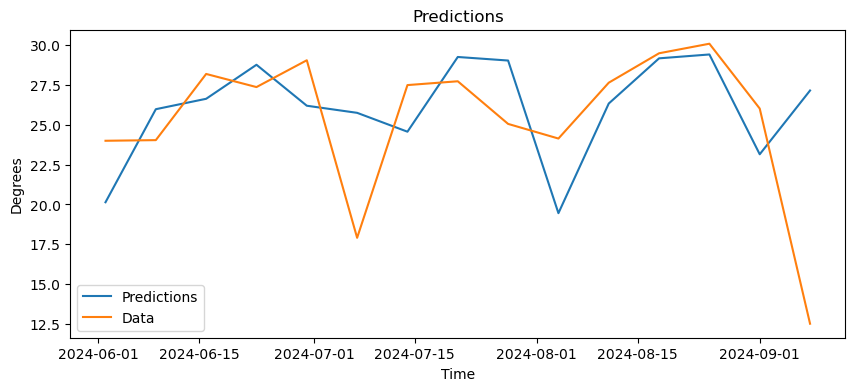

In [26]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, label='Predictions')
plt.plot(test_data, label='Data')
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('Degrees')
plt.legend()

Text(0, 0.5, 'Degrees')

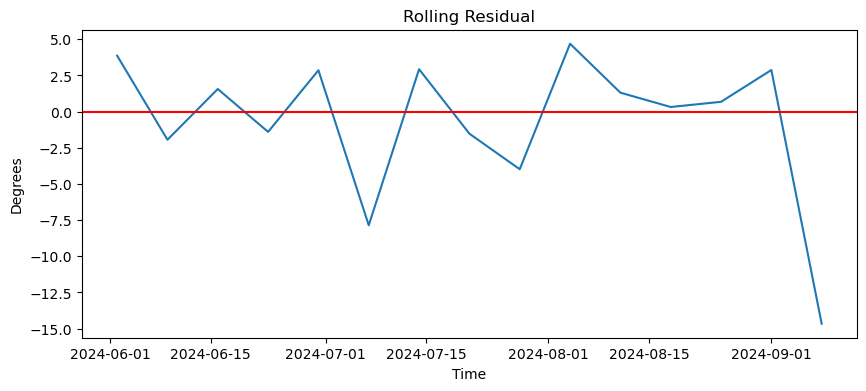

In [27]:
rolling_residual = test_data['Texas'] - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residual)
plt.axhline(y=0, color = 'r')
plt.title('Rolling Residual')
plt.xlabel('Time')
plt.ylabel('Degrees')

In [28]:
print('Mean abs % error:',np.mean(abs(rolling_residual/test_data['Texas'])))

Mean abs % error: 0.1842924587800957


In [29]:
print('Root mean squared error (degrees):',np.sqrt(np.mean(rolling_residual**2)))

Root mean squared error (degrees): 4.947981722324999
